In [ ]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import tensorflow as tf
from tkinter import Tcl
import pickle

In [ ]:
root_dir = 'mask rcnn'
assert os.path.exists(root_dir), 'ROOT_DIR does not exist. Did you forget to read the instructions above? ;)'

In [ ]:
sys.path.append(root_dir) 
from mrcnn.config import Config
import mrcnn.utils as utils
from mrcnn import visualize
import mrcnn.model as modellib

In [ ]:
model_dir = os.path.join(root_dir, 'logs')
# Directory to save trained model

coco_model_path = os.path.join(root_dir,'mask_rcnn_coco.h5')

if not os.path.exists(coco_model_path):
    utils.download_trained_weights(coco_model_path)


In [ ]:
class CrystalConfig(Config):
    """Configuration for training on the Hydrate Crystal dataset.
    Derives from the base Config class and overrides values specific
    to the Hydrate Crystal dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Hydrate_Crystal"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 1 (cig_butt)

    # All of our training images are 576x576
    IMAGE_MIN_DIM = 576
    IMAGE_MAX_DIM = 576

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = CrystalConfig()
config.display()

In [ ]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
                
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                #print(segmentation)
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

In [ ]:

dataset_train = CocoLikeDataset()
dataset_train.load_data('mask rcnn/dataset/Train.json', 'mask rcnn/dataset/train')
dataset_train.prepare()

dataset_val = CocoLikeDataset()
dataset_val.load_data('mask rcnn/dataset/Test.json', 'mask rcnn/dataset/test')
dataset_val.prepare()

In [ ]:
dataset = dataset_train
#image_ids = np.random.choice(dataset.image_ids,20)
image_ids = dataset.image_ids
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)
    


In [ ]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=model_dir)

In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(coco_model_path, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [ ]:
#m_path = os.path.join('mask rcnn', 'logs', 'hydrate_crystal20210601T1513', 'mask_rcnn_hydrate_crystal_0008.h5')
#model.load_weights(m_path, by_name = True)

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=4, 
            layers='heads')
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
start_train = time.time()
model.train(dataset_train, dataset_val, learning_rate=config.LEARNING_RATE / 10, epochs=8, layers="all")
end_train = time.time()
minutes = round((end_train - start_train) / 60, 2)
print(f'Training took {minutes} minutes')

In [10]:
class InferenceConfig(CrystalConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 576
    IMAGE_MAX_DIM = 576
    DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [11]:

model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=model_dir)

In [12]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
#model_path = os.path.join('mask rcnn', 'logs', 'hydrate_crystal20210601T1513', 'mask_rcnn_hydrate_crystal_0008.h5')
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  mask rcnn\logs\hydrate_crystal20210714T1625\mask_rcnn_hydrate_crystal_0008.h5
Re-starting from epoch 8


In [13]:
def get_area_and_arclength(masks):
    #get the area and the arclength of the mask, input is the binary masks from .detect()
    h, w, l = masks.shape
    area = 0
    arclength = 0
    for k in range(0, l):
        for i in range(0, h):
            for j in range(0, w):
                if masks[i][j][k] == True:
                    area += 1
                    
                    if j-1 > 0 and j+1 < w:
                        # check if at the edge of an image
                        
                        if masks[i][j-1][k] == False or masks[i][j+1][k] == False:
                            arclength += 1
                            
    return area, arclength
    


In [14]:
def calculate_speed(areas, arclengths):
    '''
    Calculate the crystal growing speed from a list of areas and arclengths corresponding to each frame of the video
    Both input are lists
    '''
    delta_As = []
    delta_Ls = []
    for i in range(0, len(areas)):
        if i >=1:
            delta_A = areas[i]-areas[i-1]
            delta_As.append(delta_A)
    for i in range(0, len(arclengths)):
        if i >= 1:
            delta_L = arclengths[i] - arclengths[i-1]
            delta_Ls.append(delta_L)
    delta_As = np.array([delta_As])
    delta_Ls = np.array([delta_Ls])
    sum_A = np.sum(delta_As)
    sum_L = np.sum(delta_Ls)
    speed = sum_A/(sum_L*len(areas))
    
    print('The crystal growing speed is ', speed, ' pixels per frame')
    return speed
    


Processing 1 images
image                    shape: (576, 576, 3)         min:   16.00000  max:  203.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -107.70000  max:   99.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32

*** No instances to display *** 



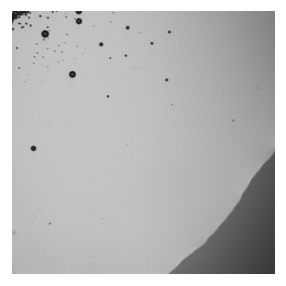

Processing 1 images
image                    shape: (576, 576, 3)         min:   16.00000  max:  202.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -107.70000  max:   98.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32

*** No instances to display *** 



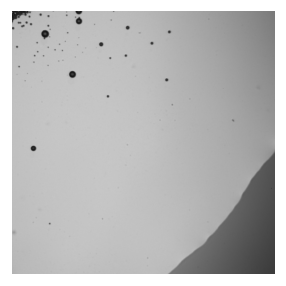

Processing 1 images
image                    shape: (576, 576, 3)         min:   15.00000  max:  206.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -108.70000  max:  102.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32

*** No instances to display *** 



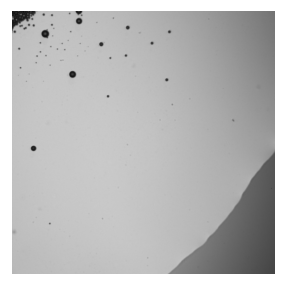

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  205.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:  101.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32

*** No instances to display *** 



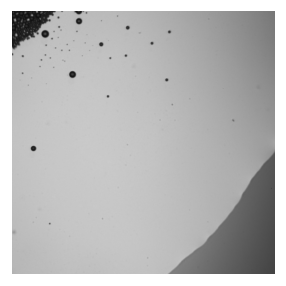

Processing 1 images
image                    shape: (576, 576, 3)         min:    9.00000  max:  200.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -114.70000  max:   96.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


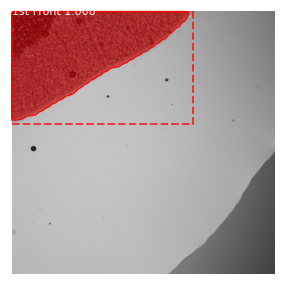

Processing 1 images
image                    shape: (576, 576, 3)         min:   10.00000  max:  202.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -113.70000  max:   98.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


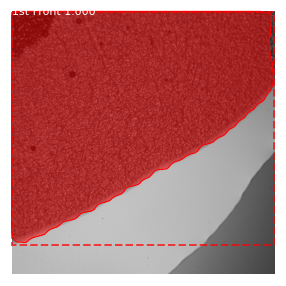

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  198.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   94.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


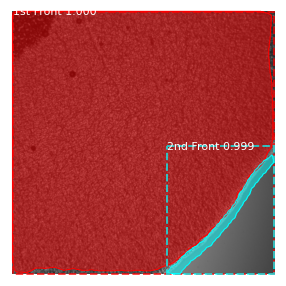

Processing 1 images
image                    shape: (576, 576, 3)         min:   10.00000  max:  190.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -113.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


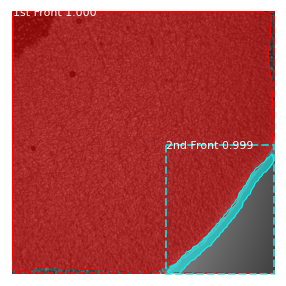

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  194.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   90.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


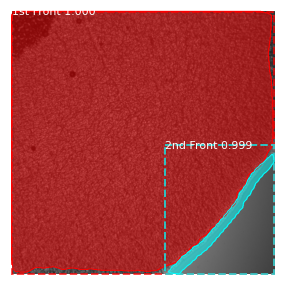

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  186.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


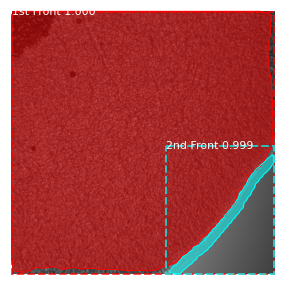

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  190.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


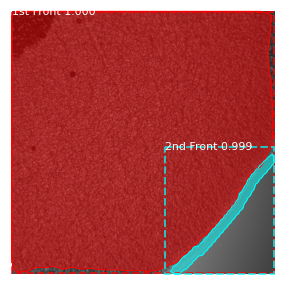

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  192.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   88.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


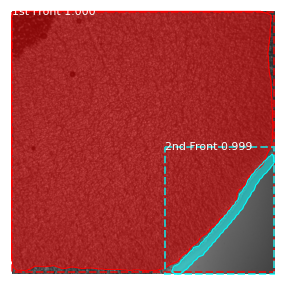

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  185.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   81.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


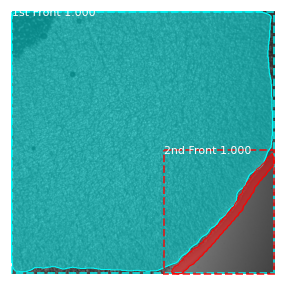

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  190.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


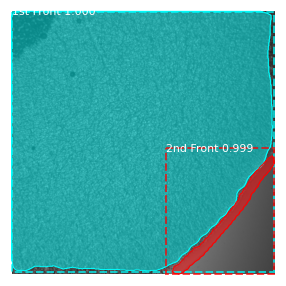

Processing 1 images
image                    shape: (576, 576, 3)         min:   13.00000  max:  184.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -110.70000  max:   80.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


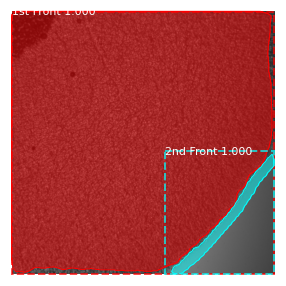

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  183.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   79.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


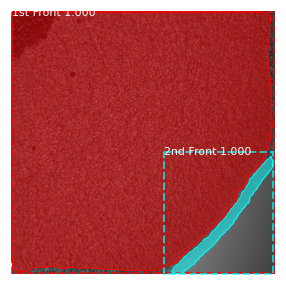

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  192.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   88.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


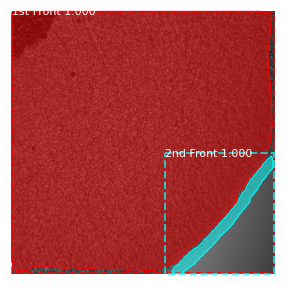

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  192.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   88.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


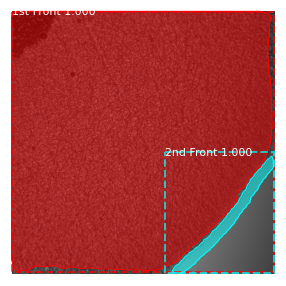

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  186.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


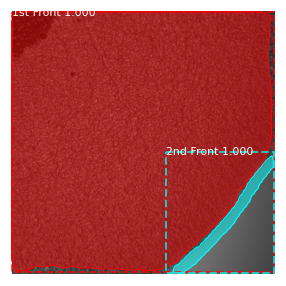

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  187.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   83.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


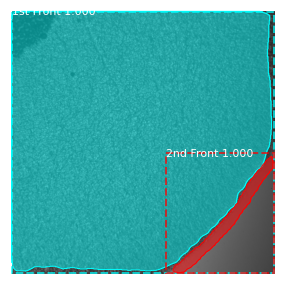

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  188.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   84.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


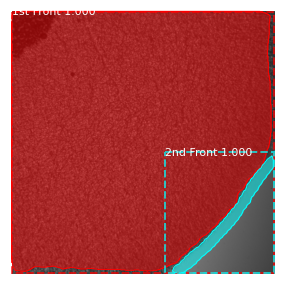

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  185.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   81.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


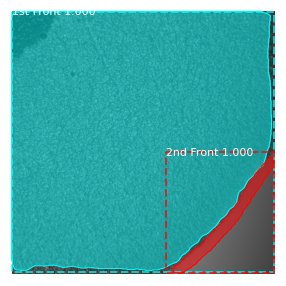

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  186.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   82.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


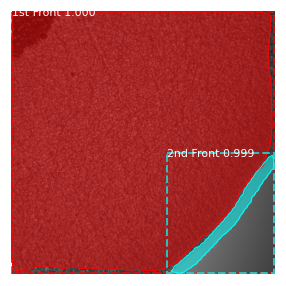

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  187.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   83.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


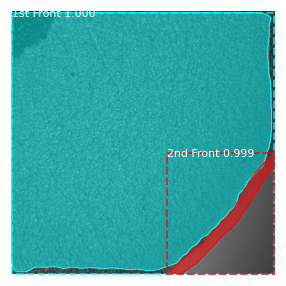

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  184.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   80.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


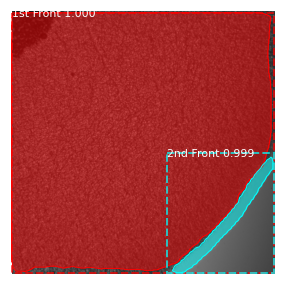

Processing 1 images
image                    shape: (576, 576, 3)         min:   13.00000  max:  185.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -110.70000  max:   81.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


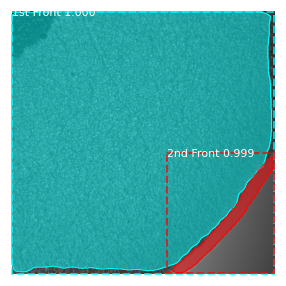

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  187.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   83.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


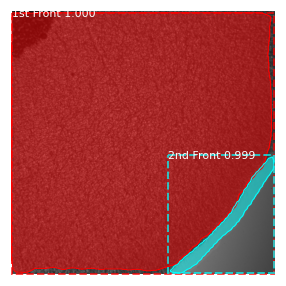

Processing 1 images
image                    shape: (576, 576, 3)         min:   11.00000  max:  191.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -112.70000  max:   87.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


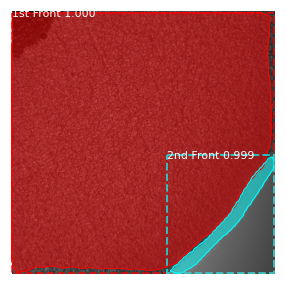

Processing 1 images
image                    shape: (576, 576, 3)         min:   12.00000  max:  190.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -111.70000  max:   86.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


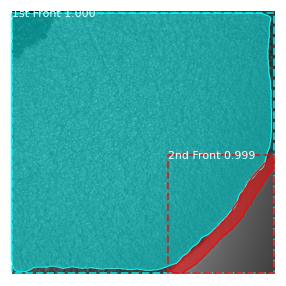

Processing 1 images
image                    shape: (576, 576, 3)         min:   13.00000  max:  181.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -110.70000  max:   77.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


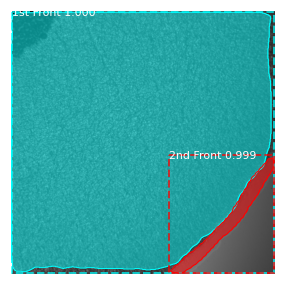

Processing 1 images
image                    shape: (576, 576, 3)         min:   13.00000  max:  188.00000  uint8
molded_images            shape: (1, 576, 576, 3)      min: -110.70000  max:   84.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  576.00000  int32
anchors                  shape: (1, 82863, 4)         min:   -0.15741  max:    1.04610  float32


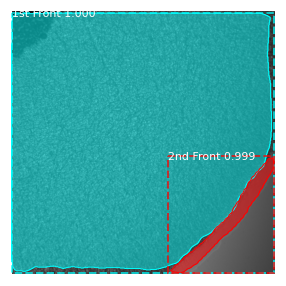

In [18]:

import skimage
real_test_dir = 'mask rcnn/dataset/3'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
    """
    r = results[0]
    
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'], figsize=(5,5))



In [ ]:
import skimage
real_test_dir = 'mask rcnn/dataset/1' # change 1 to 2 or 3 for different videos
AREA_PATH = os.path.join(real_test_dir, 'areas.txt')
ARC_PATH = os.path.join(real_test_dir, 'arclengths.txt')


if not os.path.exists(AREA_PATH) or not os.path.exists(ARC_PATH):

    image_paths = []

    for filename in os.listdir(real_test_dir):
        if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
            image_paths.append(os.path.join(real_test_dir, filename))

    areas =[]
    arclengths = []
    for image_path in image_paths:
        img = skimage.io.imread(image_path)
        img_arr = np.array(img)
        results = model.detect([img_arr], verbose=1)
        r = results[0]
        masks = np.array(r['masks'][:])
        area, arclength = get_area_and_arclength(masks)
        areas.append(area)
        arclengths.append(arclength)
        with open(AREA_PATH, 'wb') as fp:
            pickle.dump(areas, fp)
        with open(ARC_PATH, 'wb') as fp:
            pickle.dump(arclengths, fp)
        # save areas and arclengths because calculating these takes a long time


else:
    with open(AREA_PATH, 'rb') as fp:
        areas = pickle.load(fp)
    with open(ARC_PATH, 'rb') as fp:
        arclengths = pickle.load(fp)

    
    

In [ ]:
speed = calculate_speed(areas, arclengths)
